# Building a Fashion Recommender System from Learned Embeddings
```
Seyed Saeid Masoumzadeh 
Senior Data Scientist @ Lyst
Open Data Science Conference (ODSC) London - 16th June 2022
```
<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>








**The packages we need to import for this workshop**


In [1]:
import pandas as pd
import numpy as np
import fasttext
import glob
import re
import cv2
import matplotlib.pyplot as plt
from rpforest import RPForest

### Word2vec - SkipGram architecture 

```
The Skip-gram model architecture usually tries to predict the probability of the context words (surrounding words) given a target word.

```
- A shallow network including just one hidden layer
- Input size is equal to the number of unique words/phrases we have in our text/corpus
- Output size is also equal to the number of unique words/phrases we have in our text/corpus

![title](img/skipgram.png)

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

### Word2vec - Data Sampling 
```
the word2vec data sampling using a sliding window strategy whereby the window size specifies how many next or previous token must be considered to be paired with a given token in the window.
```

![title](img/sampling.png)

## Writing a method to do sampling using sliding window

In [2]:
def sample_data(sequence, window_size):
    """
    This function provides a sampling using a window strategy, the window moves on the sequence
    of link_ids and the positives are selected in the scope of the window. e.g, if a list of sequence is
    [1,2,3,4] and the window is 1, the samples are [(1,2), (2,1), (2,3), (3,2), (3,4), (4,3)].
    """

    number_of_tokens = len(sequence)
    samples = []
    for i in range(number_of_tokens):
        nbr_inds = list(range(max(0, i - window_size), i)) + list(
            range(i + 1, min(number_of_tokens, i + window_size + 1))
        )
        for j in nbr_inds:
            samples.append((sequence[i], sequence[j]))
    return samples

In [3]:
sequence = ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
sample_data(sequence, window_size = 2)

[('the', 'quick'),
 ('the', 'brown'),
 ('quick', 'the'),
 ('quick', 'brown'),
 ('quick', 'fox'),
 ('brown', 'the'),
 ('brown', 'quick'),
 ('brown', 'fox'),
 ('brown', 'jumps'),
 ('fox', 'quick'),
 ('fox', 'brown'),
 ('fox', 'jumps'),
 ('fox', 'over'),
 ('jumps', 'brown'),
 ('jumps', 'fox'),
 ('jumps', 'over'),
 ('jumps', 'the'),
 ('over', 'fox'),
 ('over', 'jumps'),
 ('over', 'the'),
 ('over', 'lazy'),
 ('the', 'jumps'),
 ('the', 'over'),
 ('the', 'lazy'),
 ('the', 'dog'),
 ('lazy', 'over'),
 ('lazy', 'the'),
 ('lazy', 'dog'),
 ('dog', 'the'),
 ('dog', 'lazy')]

```

For the sample (quick, brown), the input to word2vec model is a one-hot vector where all the cells are zeros except the cell pointing to the word quick,  which is initialized with 1. The output is again a one-hot vector where all the cells are zeros except the cell pointing to the word brown. Briefly speaking word2vec can be considered as a multi class classifier and can be solved using a sampled softmax loss.  
```


```
A sentence is a sequence of words, and Word2vec using skip-gram model tries to find the probability of the surrounding words given a word. Is it a concept that we can apply on the other sequences?
```

### Reading session data

This is an anonymized data, showing the users' interactions in terms of clicking on the items, for example in a fashion platform like Lyst. 
- the session_id represnts a user
- the product_id represents a fashion product/clothing item has been clicked by the user
- the event_time_stamp is the time the click event occurred

In [4]:
data = pd.read_parquet("data/data.parquet")
data.head()

,session_id,product_id,event_time_stamp
0,rziilb8xngl7axi,1544477,2022-06-04 00:00:00.430
1,yk1ibw2nevwyant,1360865,2022-06-04 00:00:00.563
2,j80ucwafjg3gsm7,1505732,2022-06-04 00:00:00.572
3,ptdwim37jh3fwyf,1351180,2022-06-04 00:00:01.760
4,tpvq343wxo4xvg0,1550991,2022-06-04 00:00:02.620


### Sorting by event time stamp

In [5]:
data = data.sort_values('event_time_stamp')
data.head()

,session_id,product_id,event_time_stamp
0,rziilb8xngl7axi,1544477,2022-06-04 00:00:00.430
1,yk1ibw2nevwyant,1360865,2022-06-04 00:00:00.563
2,j80ucwafjg3gsm7,1505732,2022-06-04 00:00:00.572
3,ptdwim37jh3fwyf,1351180,2022-06-04 00:00:01.760
4,tpvq343wxo4xvg0,1550991,2022-06-04 00:00:02.620


### Representing the sequence of clicks
```
grouping the data by session_id allows us to build the product_id sequences which have been clicked by the users. Each sequence has been sorted by the time the click occurred as a result of the previous sorting logic.
```  

In [6]:
data['product_id'] = data['product_id'].astype(str)
session_seq = data.groupby('session_id')['product_id'].apply(list).reset_index(
).rename(columns={'product_id':"sequence_of_clicks"})
session_seq.head()

,session_id,sequence_of_clicks
0,000eptzzospsbvn,"[1552213, 1493234]"
1,000njqw1yn9cnot,"[1359923, 1523887]"
2,002hjgmszqnjax9,"[1463503, 1418365, 1531480]"
3,002sayrysl2kwpj,"[1370197, 1504305]"
4,002wwkzgr4eqzzo,"[1547253, 1362133, 1406687]"


### Some data exploration on sequences

**Checking the sequence length**

In [7]:
session_seq['sequence_length'] = session_seq['sequence_of_clicks'].apply(lambda x: len(x))
session_seq.head()

,session_id,sequence_of_clicks,sequence_length
0,000eptzzospsbvn,"[1552213, 1493234]",2
1,000njqw1yn9cnot,"[1359923, 1523887]",2
2,002hjgmszqnjax9,"[1463503, 1418365, 1531480]",3
3,002sayrysl2kwpj,"[1370197, 1504305]",2
4,002wwkzgr4eqzzo,"[1547253, 1362133, 1406687]",3


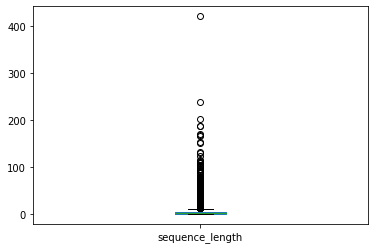

In [8]:
session_seq['sequence_length'].plot.box()

**Removing the outliers**

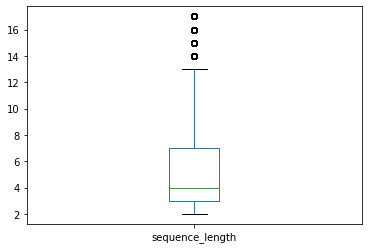

In [9]:
session_seq = session_seq[session_seq['sequence_length'] <= session_seq['sequence_length'].quantile(0.95)]
session_seq = session_seq[session_seq['sequence_length'] >= 2]
session_seq['sequence_length'].plot.box()

**Length ferequency**
<br/><br/>
give us a better insight how to select the window size in sampling

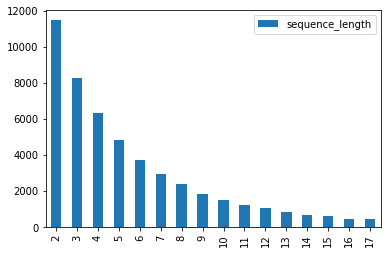

In [10]:
session_seq['sequence_length'].value_counts().to_frame().plot.bar()

In [11]:
sample_data(['1463503', '1418365', '1531480'],  2)

[('1463503', '1418365'),
 ('1463503', '1531480'),
 ('1418365', '1463503'),
 ('1418365', '1531480'),
 ('1531480', '1463503'),
 ('1531480', '1418365')]

### Running SkipGram (using fasttext) on the sequences

parameters:
- ws: Window size
- dim: Dimension of the vectors learned by model (the number of neurons in the hidden layer)
- minCount: Ignore tokens with a frequency below this threshold
- maxn and minn: Control the character ngram which is not used in our case (maxn=0 disable character ngram)
- neg: Number of negative words to sample
- wordNgrams: max length of word ngram
- loss: loss function

In [12]:
fasttext_params = {
            "model": "skipgram",
            "lr": 0.05,
            "dim": 100,
            "ws": 3,
            "epoch": 100,
            "minCount": 1,
            "minn": 3,
            "maxn": 0,
            "neg": 5,
            "wordNgrams": 1,
            "loss": "ns",
            "thread": 24,
            "verbose": 2,
        }
sequence_txt_file = 'data/seq.txt'
sequence = [' '.join(x) for x in session_seq['sequence_of_clicks'].values]
np.savetxt(sequence_txt_file, sequence, fmt="%s", encoding="utf-8")
model = fasttext.train_unsupervised(sequence_txt_file, **fasttext_params)

### Generating Embeddings

In [13]:
vectors = np.vstack([model[x] for x in model.words]).astype("double")
vocabs = model.words

vectors_dict = dict(zip(vocabs, vectors))

In [14]:
vectors_dict['1531480']

array([-0.15974151,  0.50016111,  0.11144283, -0.04019883,  0.02896135,
        0.55747342, -0.86979032, -0.08291665,  0.51260394,  0.27334294,
       -0.47522667,  0.08812857,  0.07488676,  0.43909878, -0.05552055,
       -0.04158247, -0.2015339 , -0.28238773, -0.42234358, -0.65958047,
        0.04894902,  0.29460537, -0.43803856, -0.06939999, -0.06325313,
       -0.55731052,  0.04237491, -0.48052377, -0.46020526, -0.17407413,
       -0.00897498,  0.30841878, -0.64709556, -0.2826674 , -0.83953768,
       -0.94493467, -0.27746624, -0.64463383, -0.34668419, -0.14304832,
        0.70877218,  0.12719856, -0.40048179,  0.10615008,  0.24696551,
        0.80220497,  0.05904085, -0.10763492,  0.11501101,  0.85547256,
       -0.3877537 , -0.22469091,  0.2255317 ,  0.59263337,  0.0093963 ,
        0.31375653, -0.16288514, -0.06222888, -0.63547313, -0.77470285,
        0.47641191,  0.25767127,  0.54996759,  0.39072996, -0.03254315,
        0.39712963, -0.11045434,  0.24671383,  0.65878993,  0.19

### Cosine similarity

In [15]:
import numpy as np


def cos_sim(a, b):
    """
    Takes 2 ndarray and  a, b and returns the cosine similarity according
    to the definition of the dot product.
        a should be a single 1-d array
        b should be a 2-d array
    """

    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b, axis=1)
    return np.dot(a, b.T) / (norm_a * norm_b)

### Build a hash table for (product_id, image)

In [16]:
files = glob.glob('product_images/*.jpeg')
file_dict = {}
for file in files:
    result = re.search('images/(.*).jpeg', file)
    file_dict[result.group(1)] = file   

### Finding similar items to a given item 

In [17]:
sims = cos_sim(vectors_dict['1556752'], vectors)
sims = sorted(zip(vocabs, sims), key=lambda x: x[1], reverse=True)[:9]
print(sims)

[('1556752', 1.0), ('1387755', 0.9302316584339484), ('1550991', 0.9062990540656122), ('1512698', 0.8844341504834112), ('1361244', 0.8774410995339641), ('1475404', 0.8756819063672393), ('1434085', 0.8442907369873488), ('1524895', 0.8395499202229045), ('1458552', 0.8385506282442269)]


In [18]:
images = []
for product_id, sim in sims: 
    images.append(file_dict[product_id]) 

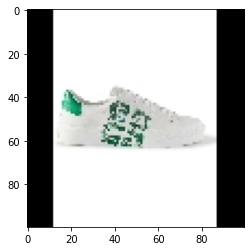

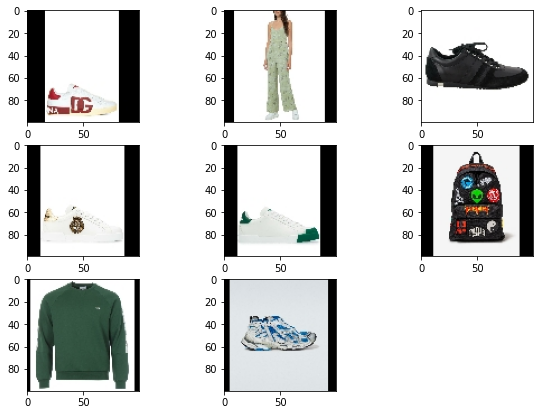

In [19]:
img = cv2.imread(images[0], cv2.IMREAD_COLOR)
plt.imshow(img[:,:,::-1])


fig = plt.figure(figsize=(10, 7))
i = 1
for image in images[1:]:
    img =  cv2.imread(image, cv2.IMREAD_COLOR)
    ax = fig.add_subplot(3, 3, i)
    plt.imshow(img[:,:,::-1])
    i = i + 1

### Approximate Nearest Neighbor (ANN)

```
Finding points in a high-dimensional space that are close to a given query point in a fast but approximate manner.

In each tree, the set of training points is recursively partitioned into smaller and smaller subsets until a leaf node of at most M points is reached. Each partition is based on the cosine of the angle the points make with a randomly drawn hyperplane: points whose angle is smaller than the median angle fall in the left partition, and the remaining points fall in the right partition.
```

![title](img/rpforest.png)

### Train rpforest

In [27]:
rpf_model = RPForest(leaf_size=50, no_trees=10)
rpf_model.fit(vectors)

### Finding similar items by making query to ANN

In [28]:
sims_index = rpf_model.query(vectors_dict['1556752'], 9)
sims = [vocabs[i] for i in sims_index]

In [29]:
images = []
for product_id in sims:
    try:
        images.append(file_dict[product_id])
    except KeyError:
        continue

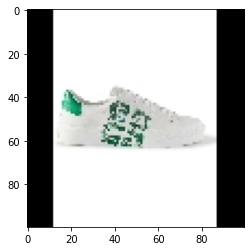

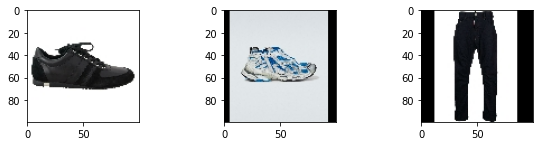

In [30]:
img = cv2.imread(images[0], cv2.IMREAD_COLOR)
plt.imshow(img[:,:,::-1])


fig = plt.figure(figsize=(10, 7))
i = 1
for image in images[1:]:
    img =  cv2.imread(image, cv2.IMREAD_COLOR)
    ax = fig.add_subplot(3, 3, i)
    plt.imshow(img[:,:,::-1])
    i = i + 1

### Cold start problem

Cold start heppens in this steup when an item have some content information but no interactions are present
 - **An efficnet solution would be using a triplet neural network**
 
Triplet NN helps us to learn distributed embedding by the notion of similarity and dissimilarity. It's a kind of neural network architecture where multiple parallel networks are trained that share weights among each other.


![title](img/triplet_NN.png)

![title](img/triplet_rec_embeddings.png)

### Sampling Anchor, Positive and Negative
sampling anchor and positive is the same as what has been explained in Item2vec approach

In [35]:
samples = sample_data(['1463503', '1418365', '1531480'],  2)
samples

[('1463503', '1418365'),
 ('1463503', '1531480'),
 ('1418365', '1463503'),
 ('1418365', '1531480'),
 ('1531480', '1463503'),
 ('1531480', '1418365')]

All samples

In [70]:
all_samples = session_seq['sequence_of_clicks'].apply(lambda x:sample_data(x, 2))
all_samples = np.concatenate(all_samples.values)

In [76]:
df = pd.DataFrame(all_samples, columns=['anchor', 'positive'])
df.head()

,anchor,positive
0,1552213,1493234
1,1493234,1552213
2,1359923,1523887
3,1523887,1359923
4,1463503,1418365


What about negatives???
the negatives are sampled randomly

In [79]:
df['negative'] = df['positive'].sample(frac=1).reset_index(drop=True)
df.head()

,anchor,positive,negative
0,1552213,1493234,1360042
1,1493234,1552213,1455816
2,1359923,1523887,1478708
3,1523887,1359923,1362036
4,1463503,1418365,1358825


### Triplet loss

L(a, p, n) = max(0, D(a, p) — D(a, n) + margin)

In [ ]:
def triplet_loss(a, p, n, margin):
    dist_a_p = 1 - cos_sim(a, p.reshape(1, -1))[0]
    dist_a_n = 1 - cos_sim(a, n.reshape(1, -1))[0]
    return max(dist_a_p - dist_a_n + margin, 0)

The higher margin, the softer negatives contributes into the cost  

In [ ]:
a = vectors_dict['1556752']
p = vectors_dict['1387755']
s_n = vectors_dict['1418365'] #soft_negative
s_h = vectors_dict['1451117'] #hard_negative

triplet_loss(a, p, s_h, margin= 0.5)